In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import glob #glob is a python version of running the UNIX ls command. Comes in handy for finding files
import pandas as pd
from astropy.io import fits
from astropy.table import Table
from astropy.coordinates import SkyCoord
from astropy import units as u
from astroquery.cadc import Cadc #This is the import of specifc archive of Astroquery

# Step 1: Find the object's spectrum from coordinates

In [2]:
def get_images_from_list(image_list, show_progress=False):
    """Returns lists of HDUs from given image list URLS"""
    from astroquery.utils import commons
    fits_list = []
    fn = [commons.FileContainer(url, encoding='binary',show_progress=show_progress) for url in image_list]
    for f in fn:
        try:
            fits_list.append(f.get_fits())
        except:
            pass
    return fits_list

In [3]:
def find_obj_spectrum(fitsname):
    """Finds the object's spectrum from it's coordinates.
    Takes in the FITS name from catalog"""
    
    cat_tab = Table.read(fitsname, format='fits')
    
    
    secondary = cat_tab['f_primary'] != 1 
    good_z = cat_tab['f_z'] == 0
    good_sn = cat_tab['SN'] >= 20
#     good_spec = cat_tab['f_spec'] == 0
    mask = np.all([secondary, good_z, good_sn], axis=0) #Neat use of np.all to do a logical and across the 4 boolean arrays, ~ is negation
#     print("%d objects found."%(mask.sum()))

    # Grabbing the coordinates of the objects of interest
    samp_filenames = cat_tab['Filename'][mask]
    samp_ra = cat_tab['RAJ2000'][mask]
    samp_dec = cat_tab['DECJ2000'][mask]
    samp_specid = cat_tab['SPECT_ID'][mask]
    samp_z = cat_tab['z'][mask] # collecting redshift data
    
    #Dictionary of each fits file we found, with its corresponding ra and dec as the values
    files_and_coords = {filename:[ra,dec] for filename, ra, dec in zip(samp_filenames, samp_ra, samp_dec)}
    
#     for key in files_and_coords:
#         print(key, files_and_coords[key])

#     print((list(files_and_coords.values())))
    
    
#     object_coordinates = list(files_and_coords.values()) # list of list of ra&dec

#     create_axes(files_and_coords)
    
    return files_and_coords


#     return files_and_coords
#### We will want to loop over to plot each image for the files in samp_filenames ...
#### So we want to loop over all the coords in samp_ra and samp_dec lists

#### samp_filenames[0]  ---> samp_ra[0]  -----> samp_dec[0]
    
obj_coordinates = find_obj_spectrum('./legac_dr2_cat.fits')

In [4]:
# Grab HST cutout from coordinates

# def get_HST_image_cutouts(ra, dec, radius = 5.5*u.arcsecond):
def get_HST_image_cutouts(object_info, radius=5.5*u.arcsecond):
    """Grab HST image cutouts from object's coordinates."""

    object_coordinates = list(object_info.values()) # object_coordinates is now a list of list of ra&dec
    
    #Query HST Database
    total_fits_list = []
    # ITERATING THRU ALL COORDINATES
    for ra_and_dec in object_coordinates:  # iterates thru each pair of coordinates for each fits
        ra = ra_and_dec[0] # first item in each coordinates_list is the ra
        dec = ra_and_dec[1] # second item in each coordinates_list is the dec
        
        #Create SkyCoord object using Astropy and the object's coordinates
        coords = SkyCoord(ra=ra*u.degree,dec=dec*u.degree)
    #     radius = 5.5*u.arcsecond//

        #Create a CADC object and query it using query region (coordinates and cutout around our object) for the HST collection
        cadc = Cadc()
        result = cadc.query_region(coords,radius=radius,collection='HST')

        #Select entries above calibration level 2 and for the ACS instrument
        result_cal = result[np.logical_and(result['calibrationLevel'] > 2,result['instrument_name'] == 'ACS/WFC')]
        #Grabs composite images
        result_comp = result_cal[result_cal['typeCode']=='C']

        #Take results and find image list

        image_list = cadc.get_image_list(result_comp,coordinates=coords,radius=radius)
    #     print(image_list)

        #Grab FITS HDUlists from image_list (which is a list of URLs)
        fits_list = get_images_from_list(image_list)
        
        #Create dummy image to add to fits list  
        #So we wont get an error later if no images were found for some fits files
        dummy_image = np.zeros((255,256)) 
        
        if len(fits_list) == 0:
            fits_list.append([dummy_image])
        
        
        for fits in fits_list:
            if len(fits) == 0:
                fits.append(dummy_image)            
        
        total_fits_list.append(fits_list)
        
#         try:
        # if fits_list was not empty, try to get the photname / units n other info from the header

#         except:
        # except if the fits_list is empty or if it couldnt find the ['SCI'] extension or whatever,
        # (which means the image is the dummy image), then just plot the np.zeros dummy image
    
    
    return total_fits_list
    
fits_list_HST = get_HST_image_cutouts(obj_coordinates)
print(len(fits_list_HST), fits_list_HST)

7 [[[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fe2434408b0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fe2434346d0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fe243440100>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fe243434070>]], [[<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fe24312d040>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fe2436956a0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fe243695fd0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fe2436c38b0>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fe24323b7c0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fe2436cdac0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fe2436d9490>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fe2436d9cd0>], [<astropy.io.fits.hdu.image.PrimaryHDU object at 0x7fe2436ab730>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fe2436e6ee0>, <astropy.io.fits.hdu.image.ImageHDU object at 0x7fe2436f38b0>, <astropy.io.fits.hdu.image.ImageHD

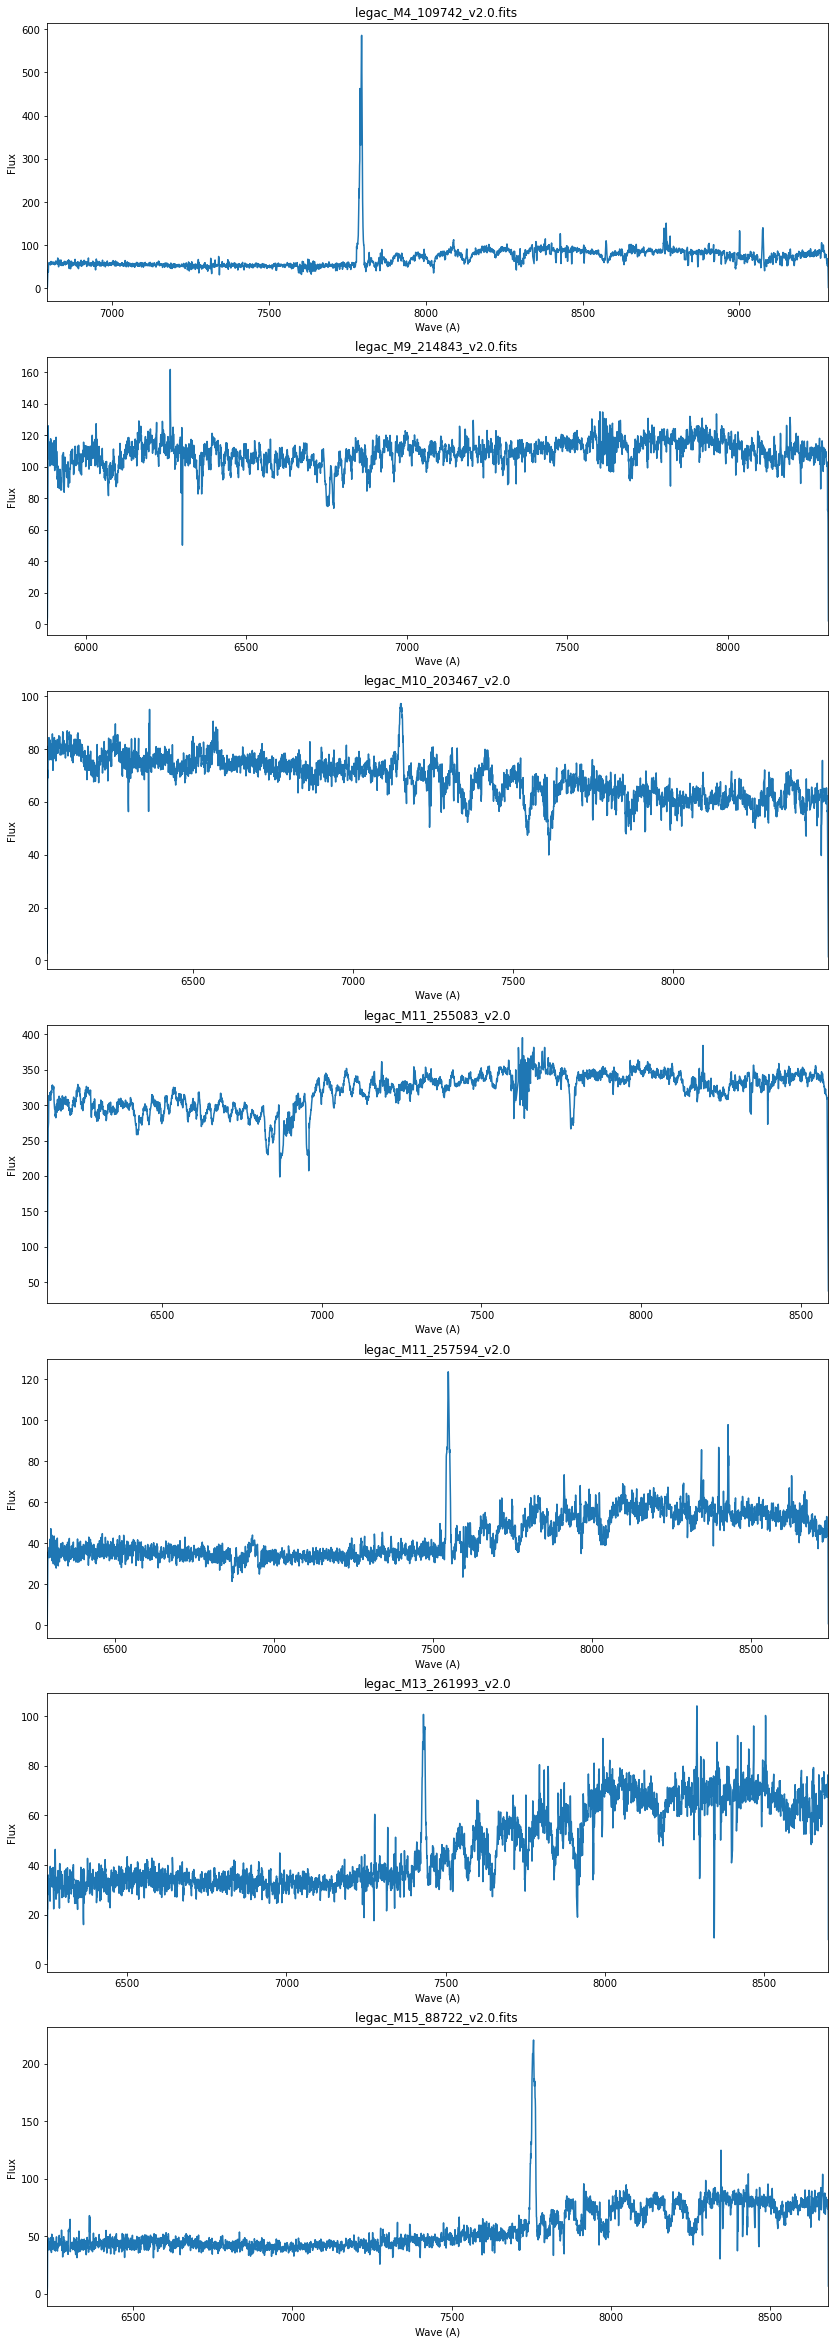

In [5]:
def create_axes(files_and_coords):
    """Returns subplot axes object of spectra for each fits file"""
    spectra_filenames = list((files_and_coords.keys()))
    plot_counter = 0 
    
    num_of_plots = len(spectra_filenames)
    
    # to keep figsize proportional: figsize=(8*2,6)
    xdim = num_of_plots *2
    ydim = num_of_plots *6 
    
    fig, axs = plt.subplots(num_of_plots, figsize=(xdim,ydim))# plt.figure(figsize=(xdim,ydim)).subplots(num_of_plots, 2)# sharey=True)

    
    
    for file in spectra_filenames:
        
        obj0 = fits.open('./spectraDR/'+file.strip())
        wave = obj0[1].data['WAVE'][0]
        flux = obj0[1].data['FLUX'][0]

        #Masking to plot only nonzero values of flux (to just look at the interesting parts of the spectra)
        flux_cutoff = np.where(flux != 0)
        flux = flux[flux_cutoff]

        #Plot wave only where flux != 0
        wave = wave[flux_cutoff]

#         axs = plt.figure(figsize=(8*2,6)).subplots(plot_counter, 2,)
        axs.flat[plot_counter].plot(wave, flux, '-')
        axs.flat[plot_counter].set_xlabel('Wave (A)')
        axs.flat[plot_counter].set_ylabel('Flux')
        axs.flat[plot_counter].set_xlim(wave[0],wave[-1]) # set lims to fit plot to figure 
        
        spec_name = file.split('.fits')[0]
        axs.flat[plot_counter].set_title(file.strip('.fits').strip('fits'))

        
        plot_counter+=1

    
    
#     print(axs, '\n', axs.flat)
    return axs.flat


axes_practice = create_axes(obj_coordinates)

In [6]:
# pp = PdfPages('multipage_test.pdf')

def plot_fits(fits_list, spectra_axs):
    """Returns plot of cutout and spectra pairs"""
    
    from matplotlib import cm, colors
    
    pp = PdfPages('multipage_test.pdf') 
    
    total_plot_counter = 0
    local_plot_counter = 0
    page_counter = 0
    num_of_plots = len(fits_list)
    plots_per_page = 5
    tot_num_of_pages = int(np.ceil(num_of_plots / float(plots_per_page)))

    xdim = num_of_plots *2
    ydim = num_of_plots *6 
    
    col = 1
    
    # spectra_list will be the axs.flat obj passed from the create_axes function
    
#     axs = plt.figure(figsize=(xdim,ydim)).subplots(num_of_plots, 2)# sharey=True)
    
    fig, axs = plt.subplots(num_of_plots, 2, figsize=(xdim,ydim))

    for fits, spectra_ax in zip(fits_list, spectra_axs.flat):
    
#         try:
            #This conditional helps ignore some returned composite images that have nans
#             if np.isnan(fits['SCI'].data).sum() < 1:
        if local_plot_counter // 4 != 0:
    #                     fig, ax = plt.subplots(figsize=(10,10))

            photname = fits['SCI'].header['PHOTMODE']
            units = fits['SCI'].header['BUNIT']
            axs.flat[total_plot_counter].imshow(fits['SCI'].data)
#             im = ax.imshow(fits['SCI'].data)
            cbar = fig.colorbar()
            axs.set_title(photname)
            cbar.set_label(units)
            local_plot_counter +=1
            total_plot_counter +=1

            
            for ax in axs.flat:
                ax[0].plot(spectra_ax[total_plot_counter])
                ax[1].imshow(fits['SCI'].data)
            
            

        elif local_plot_counter // plots_per_page == 0:
            # initialize new figure if plot_counter mod 4 is 0 
            # using mod4 instead of mod5 because of python 0-indexing
            # to not get confused with the indexing in the subplots portion
            # 0, 1, 2, 3, 4 ----> 5 plots 


            fig, ax = plt.subplots(plots_per_page,2,figsize=(xdim,ydim))


            # reset local_plot_counter
            local_plot_counter = 0
            ax.flat[local_plot_counter].
            total_plot_counter +=1 


    
    
    axs = plt.figure().subplots(num_of_plots, 2)
                
#             else:
#                 pass
#         except: # except if the ['SCI'] thing couldnt be found because the image is an np.array of zeros aka the dummy image
#             ax.flat[local_plot_counter].imshow(fits)


        
# pp.close()

SyntaxError: invalid syntax (<ipython-input-6-f5bda3997720>, line 65)

In [ ]:
plot_fits(fits_list_HST)

In [ ]:
# for fit in fits_list_HST:
#     print((fit))
for fit in fits_list_HST[0]:
    print(fit)

In [ ]:
print(type(fits_list_HST))

In [ ]:
def plot_image_pairs(fits_list_HST):
    """Plots spectrum and image pairs for each item in fits_list_HST.
    Grabs the first 'SCI' fits extension of the first HDU list """
    
    
    

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages

def create_axes(files_and_coords):
    """Returns subplot axes object of spectra for each fits file"""
    spectra_filenames = list((files_and_coords.keys()))
    plot_counter = 0 
    
    num_of_plots = len(spectra_filenames)
    
    # to keep figsize proportional: figsize=(8*2,6)
    xdim = num_of_plots *2
    ydim = num_of_plots *6 
    
    fig, axs = plt.subplots(num_of_plots, figsize=(xdim,ydim))# plt.figure(figsize=(xdim,ydim)).subplots(num_of_plots, 2)# sharey=True)

    
    
    for file in spectra_filenames:
        
        obj0 = fits.open('./spectraDR/'+file.strip())
        wave = obj0[1].data['WAVE'][0]
        flux = obj0[1].data['FLUX'][0]

        #Masking to plot only nonzero values of flux (to just look at the interesting parts of the spectra)
        flux_cutoff = np.where(flux != 0)
        flux = flux[flux_cutoff]

        #Plot wave only where flux != 0
        wave = wave[flux_cutoff]

#         axs = plt.figure(figsize=(8*2,6)).subplots(plot_counter, 2,)
        axs.flat[plot_counter].plot(wave, flux, '-')
        axs.flat[plot_counter].set_xlabel('Wave (A)')
        axs.flat[plot_counter].set_ylabel('Flux')
        axs.flat[plot_counter].set_xlim(wave[0],wave[-1]) # set lims to fit plot to figure 
        
        spec_name = file.split('.fits')[0]
        axs.flat[plot_counter].set_title(file.strip('.fits').strip('fits'))

        
        plot_counter+=1

    
    
#     print(axs, '\n', axs.flat)
    return axs.flat


# axes_practice = create_axes(obj_coordinates)

In [ ]:
# pp = PdfPages('multipage_test.pdf')
from matplotlib.backends.backend_pdf import PdfPages

def plot_spectra_and_image(fits_list, files_and_coords):
    """Returns plot of cutout and spectra pairs"""
    
    from matplotlib import cm, colors
    
#     pp = PdfPages('multipage_test.pdf') 

    spectra_filenames = list((files_and_coords.keys()))
    
    
    total_plot_counter = 0
    local_plot_counter = 0
    num_of_plots = len(fits_list)
    plots_per_page = 5
    tot_num_of_pages = int(np.ceil(num_of_plots / float(plots_per_page)))
    page_counter = 1

    xdim = num_of_plots*2
    ydim = num_of_plots*6

    
    fig, axs = plt.subplots(num_of_plots, 2, figsize=(xdim,ydim))
  

    for fits_ob, file in zip(fits_list, spectra_filenames):

#         try:
#             This conditional helps ignore some returned composite images that have nans
#             if np.isnan(fits['SCI'].data).sum() < 1:
        
#                         fig, ax = plt.subplots(figsize=(10,10))
#         fits_obj = fits_ob[0]

        # SPECTRA
        obj0 = fits.open('./spectraDR/'+file.strip())
        wave = obj0[1].data['WAVE'][0]
        flux = obj0[1].data['FLUX'][0]
        #Masking to plot only nonzero values of flux (to just look at the interesting parts of the spectra)
        flux_cutoff = np.where(flux != 0)
        flux = flux[flux_cutoff]
        #Plot wave only where flux != 0
        wave = wave[flux_cutoff]

    
            
        #IMAGE
        try:
            photname = fits_ob[0]['SCI'].header['PHOTMODE']
            units = fits_ob[0]['SCI'].header['BUNIT']

        except:
#         except if the ['SCI'].data caused an error/couldnt be found because the image is an np.array of zeros ~ dummy image
            photname = 'No image found'
            units = 'None'
            
#         if local_plot_counter+1 // plots_per_page != 0:
            # plot here  
        axs[local_plot_counter, 0].plot(wave, flux, '-')
        axs[local_plot_counter, 0].set_xlim(wave[0],wave[-1])
        axs[local_plot_counter, 0].set_title(file.strip('.fits').strip('fits'))
        axs[local_plot_counter, 0].set_xlabel('Wave (A)')
        axs[local_plot_counter, 0].set_ylabel('Flux')

        try:
            axs[local_plot_counter, 1].imshow(fits_ob[0]['SCI'].data)
            print(fits_ob[0]['SCI'].data.shape)

        except: # if no image was found ---> plot empty image 
            axs[local_plot_counter, 1].imshow(np.zeros((279,279)))
            
        axs[local_plot_counter, 1].set_title(photname)
        axs[local_plot_counter, 1].set_ylabel(units)
#             cbar = fig.colorbar()
#         axs.set_title(photname)
#             cbar.set_label(units)
        local_plot_counter +=1
        total_plot_counter +=1
        print(' 6')

#         elif local_plot_counter+1 // plots_per_page == 0:
#             # initialize new figure if plot_counter mod 4 is 0 
#             # using mod4 instead of mod5 bc of python 0-indexing
#             # to not get confused with the indexing in the subplots portion
#             # 0, 1, 2, 3, 4 ----> the 5th plot is at the 4th index

# #           pp.savefig()
#             fig, axs = plt.subplots(num_of_plots, 2, figsize=(xdim,ydim))
#             # reset local_plot_counter
#             local_plot_counter = 0
              #Plot that spectra & image 
#             axs[local_plot_counter, 0].plot(wave, flux, '-')
#             axs[local_plot_counter, 0].set_xlim(wave[0],wave[-1])
#             axs[local_plot_counter, 0].set_title(file.strip('.fits').strip('fits'))
#             axs[local_plot_counter, 0].set_xlabel('Wave (A)')
#             axs[local_plot_counter, 0].set_ylabel('Flux')
# #           try:
#                 axs[local_plot_counter, 1].imshow(fits_ob[0]['SCI'].data)
#             except: # if no image was found ---> plot empty image 
#                 axs[local_plot_counter, 1].imshow(np.zeros((279,279)))

#             axs[local_plot_counter, 1].set_title(photname)
#             axs[local_plot_counter, 1].set_ylabel(units)
# #             
#             local_plot_counter +=1
#             total_plot_counter +=1
#             page_counter += 1

# #     pp.close()
#     print(len(fits_list[0]),len(fits_list), len(spectra_filenames))
        
# # pp.close()

In [ ]:
plot_spectra_and_image(fits_list_HST, obj_coordinates)